In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.diagnostic import het_white
from statsmodels.iolib.summary2 import summary_col

import scipy
import scipy.stats as stat
from scipy.stats.distributions import gamma
from scipy.stats.stats import kendalltau


from joypy import joyplot

from functools import reduce

from functions import *

C:\Users\adria\AppData\Local\Temp\ipykernel_11204\246975071.py:17: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import kendalltau


In [2]:
fish = pd.read_csv(r'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Observational\Marine Institute\Atlantic salmon\Processed\juvenile_atlantic_salmon_2023-05-30.csv', parse_dates = ['date'])
fish = fish[(fish.lengthmm.notna())&(fish.cohort <=2019)]
fish

,cohort,date,age,dayofyear,lengthmm,river,age_class
0,1997,1997-11-23,337,327,68.0,Roug,0
1,1997,1997-11-23,337,327,70.0,Roug,0
2,1997,1997-11-25,339,329,68.0,Roug,0
3,1997,1997-12-08,352,342,71.0,Roug,0
4,1997,1997-12-08,352,342,60.0,Roug,0
...,...,...,...,...,...,...,...
35714,2017,2019-06-18,909,169,129.0,Sea-entry,2
35715,1995,1996-09-25,644,269,79.0,Roug,1
35716,1995,1996-09-25,644,269,81.0,Roug,1
35717,1995,1996-09-25,644,269,82.0,Roug,1


In [3]:
wt = pd.read_csv(r'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Simulated\Water_Temperature\Water_Temperature.csv', parse_dates=['date'], index_col = 0)
wt

,date,wt
365,1962-01-01,2.393565
366,1962-01-02,2.496376
367,1962-01-03,2.456608
368,1962-01-04,2.277996
369,1962-01-05,2.468114
...,...,...
21544,2019-12-27,5.978017
21545,2019-12-28,6.271645
21546,2019-12-29,6.285390
21547,2019-12-30,6.372072


In [4]:
def freshwater_residency(time_to_smolt, wt, fish = None):
    ''' 
    This function will make a complete timeline for each cohort
    '''
    from datetime import date, timedelta
    ### for future reference - years_to_smolt must be supplied before df
    cohort_list = []         # To store all potential cohorts
    date_list = []           # Store all dates belonging to the cohort (3 years) for Rough River
    age_list = []            # Get running age of fish from proxy spawning

    wt.set_index('date', inplace = True)

    for year in np.unique(wt.index.year):
        start_date = date(year-1, 12, 21)                   # Cohorts are assigned year for when they first appear in the dataset (usually the year following the spawning event)
        end_date = date(year+(time_to_smolt), 12, 31)        # Cohorts have different freshwater residency time, 3 in the Burrishoole and 4-6 in the Skjoma
        age = 0                                             # Have running dates from time of spawning
        for single_date in daterange(start_date, end_date):
            cohort_list.append(year)                                    # Store cohort = year in the list
            date_list.append(single_date.strftime('%Y-%m-%d'))          # Store date in the list
            age_list.append(age)                                        # Store day in the list
            linearised_cohorts = zip(cohort_list, date_list, age_list) # Merge lists
            age += 1                                                    # Increment day before next turn in the loop
    linearised_cohorts = pd.DataFrame(list(linearised_cohorts))
    linearised_cohorts = linearised_cohorts.rename(columns = {0:'cohort', 1: 'date', 2:'age'})
    linearised_cohorts.reset_index(inplace = True, drop = True)
    linearised_cohorts['date'] = pd.to_datetime(linearised_cohorts['date'])
    linearised_cohorts = pd.merge(linearised_cohorts, wt, on = ['date'], how = 'outer')
    linearised_cohorts = linearised_cohorts[linearised_cohorts.wt.notna()].reset_index(drop = True)
    if fish is not None: 
        linearised_cohorts['dd'] = linearised_cohorts.groupby('cohort').wt.cumsum()
        linearised_cohorts = pd.merge(linearised_cohorts, fish, on = ['cohort', 'date', 'age'], how = 'outer')
    else: 
        linearised_cohorts['dd'] = linearised_cohorts.groupby(['cohort', 'climate_scenario']).wt.cumsum()
    return(linearised_cohorts)


In [5]:
df = freshwater_residency(2, wt, fish)
df = df[(df.cohort >= 1963)&(df.cohort <= 2017)]
len(df[df.lengthmm.notna()])

35719

# Models
## Ordinary Least Squares

In [6]:
XX_new = []
for river in df[df.river != 'Sea-entry'].river.unique():
    XX_new.append(pd.DataFrame({'dd': np.arange(0, 10000), 'river': river}))

XX_new = pd.concat(XX_new)

In [7]:
fish_lm = smf.ols('lengthmm~dd', data = df).fit()
fish_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lengthmm   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                 2.533e+05
Date:                Mon, 19 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:30:31   Log-Likelihood:            -1.3573e+05
No. Observations:               35719   AIC:                         2.715e+05
Df Residuals:                   35717   BIC:                         2.715e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.2419      0.119    204.506      0.000      24.010      24.474
dd             0.0121   2.41e-05    503.253      0.000       0.012       0.012
==============================================================================
Omnibus:                     2049.091   Durbin-Watson:                   0.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5536.524
Skew:                           0.314   Prob(JB):                         0.00
Kurtosis:                       4.824   Cond. No.                     1.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

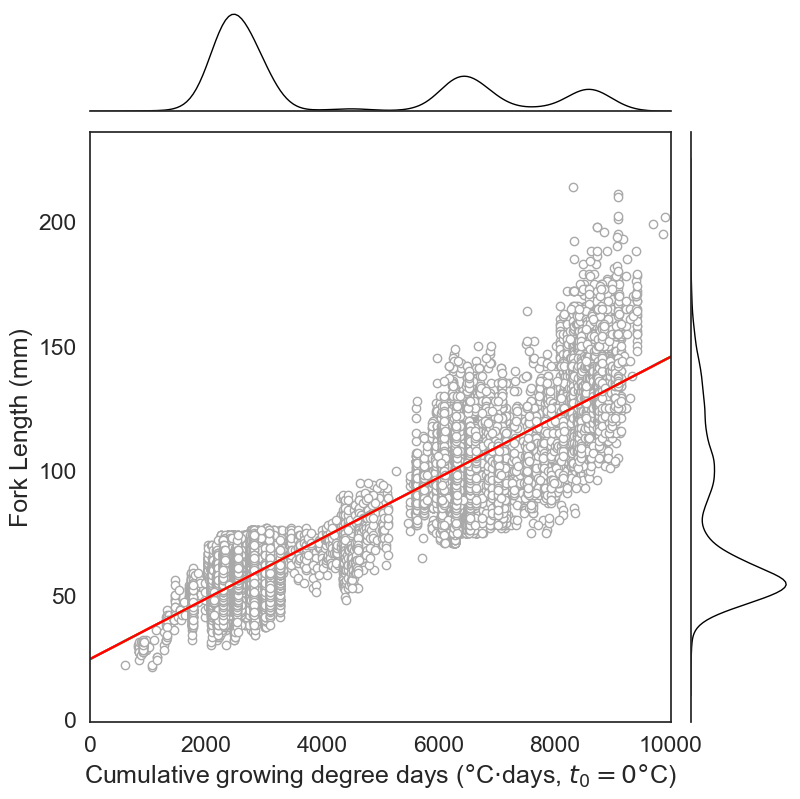

In [8]:
from matplotlib.pyplot import cm

sns.set_theme(style = 'white', font_scale = 1.5)

graph = sns.JointGrid(xlim = (0, 10000), height = 8)
x, y= df[(df.lengthmm.notna())]['dd'], df[(df.lengthmm.notna())]['lengthmm']
graph.ax_joint.scatter(x, y, color = 'white', edgecolor = 'darkgray')
sns.kdeplot(y = y, ax = graph.ax_marg_y, color = 'black', linewidth = 1)
sns.kdeplot(x = x, ax = graph.ax_marg_x, color = 'black', linewidth = 1)
XX = pd.DataFrame({'dd': np.arange(0, 10000), 'river': 'Roug'})
#graph.ax_joint.plot(XX_new.dd, fish_gamma_inv_glm.predict(XX_new), color = 'black')
color = iter(cm.rainbow(np.linspace(0, 1, len(XX_new.river.unique()))))
for river in XX_new.river.unique():
    c = next(color)
    graph.ax_joint.plot(XX_new[XX_new.river == river].dd, fish_lm.predict(XX_new[XX_new.river == river]), color = c)
graph.set_axis_labels(xlabel = r'Cumulative growing degree days ($\degree$C$\cdot$days, $t_0 = 0 \degree$C)', ylabel = r'Fork Length (mm)')
sns.despine(ax = graph.ax_joint, right = False, left = False, bottom = False, top = False)
sns.despine(ax = graph.ax_marg_x, right = True, left = True, bottom = False, top = True)
sns.despine(ax = graph.ax_marg_y, right = True, left = False, bottom = True, top = True)

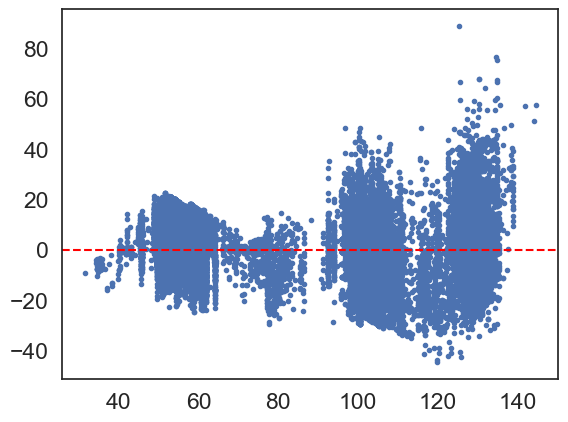

In [9]:
plt.plot(fish_lm.fittedvalues, fish_lm.resid, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

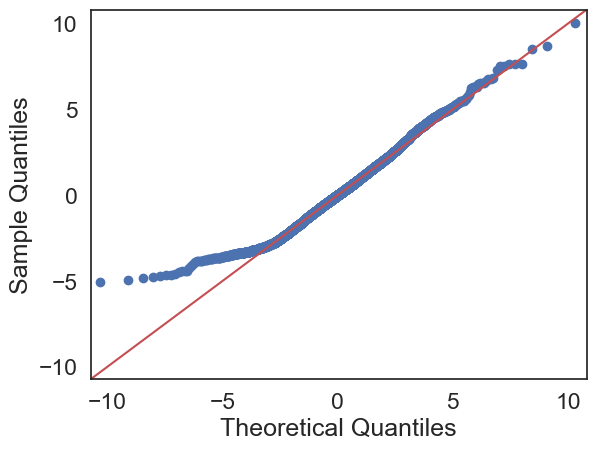

In [10]:
sm.qqplot(fish_lm.resid, dist = scipy.stats.t, fit = True, line = '45');

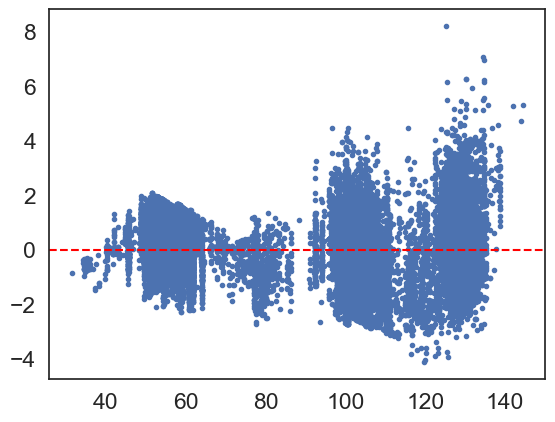

In [11]:
plt.plot(fish_lm.fittedvalues, fish_lm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

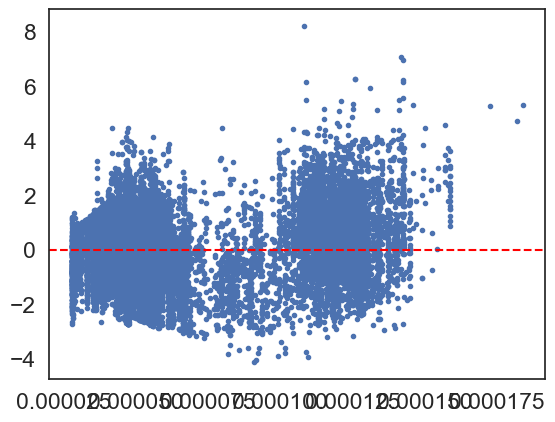

In [12]:
plt.plot(fish_lm.get_influence().hat_matrix_diag, fish_lm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

# Log-Normal Ordinary Least Squares

In [13]:
fish_lognormal_lm = smf.ols('np.log(lengthmm)~dd', data = df).fit()
fish_lognormal_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lengthmm)   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 2.459e+05
Date:                Mon, 19 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:30:35   Log-Likelihood:                 21672.
No. Observations:               35719   AIC:                        -4.334e+04
Df Residuals:                   35717   BIC:                        -4.332e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6372      0.001   2516.205      0.000       3.634       3.640
dd             0.0001   2.94e-07    495.864      0.000       0.000       0.000
==============================================================================
Omnibus:                      228.772   Durbin-Watson:                   0.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.355
Skew:                          -0.194   Prob(JB):                     2.13e-51
Kurtosis:                       3.080   Cond. No.                     1.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

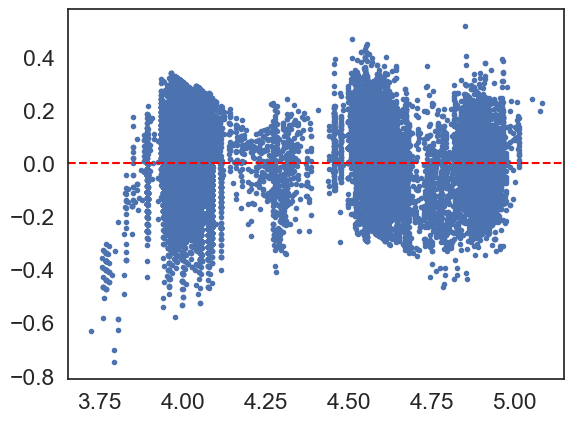

In [14]:
plt.plot(fish_lognormal_lm.fittedvalues, fish_lognormal_lm.resid, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

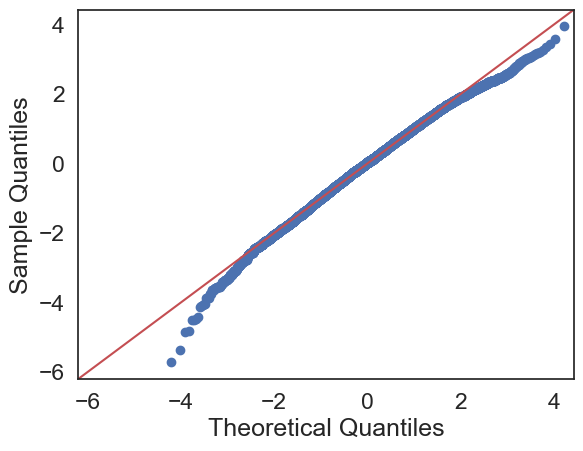

In [15]:
sm.qqplot(fish_lognormal_lm.resid, dist = scipy.stats.t, fit = True, line = '45');

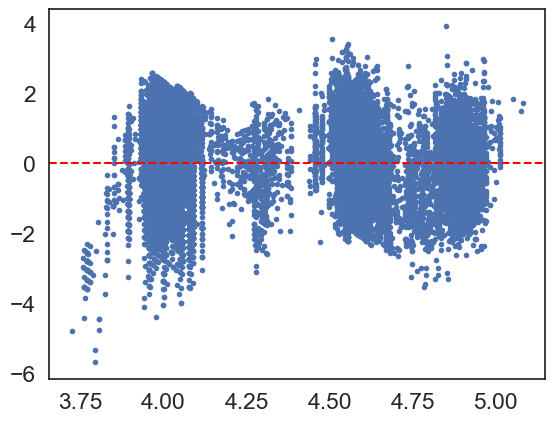

In [16]:
plt.plot(fish_lognormal_lm.fittedvalues, fish_lognormal_lm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

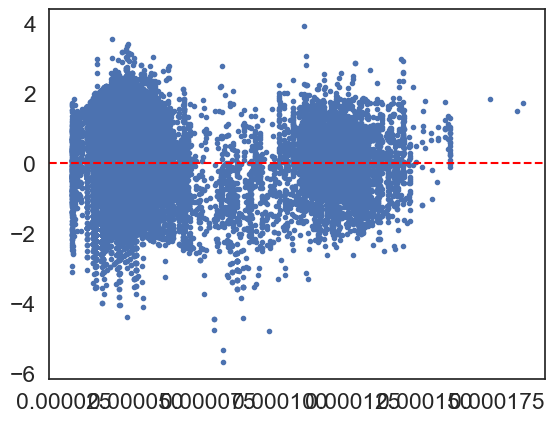

In [17]:
plt.plot(fish_lognormal_lm.get_influence().hat_matrix_diag, fish_lognormal_lm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

# Generalised Linear Models
## Gaussian Distribution Log link

In [18]:
fish_log_glm = smf.glm('lengthmm~dd', family = sm.families.Gaussian(sm.families.links.log()) , data = df).fit()
fish_log_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               lengthmm   No. Observations:                35719
Model:                            GLM   Df Residuals:                    35717
Model Family:                Gaussian   Df Model:                            1
Link Function:                    log   Scale:                          110.61
Method:                          IRLS   Log-Likelihood:            -1.3473e+05
Date:                Mon, 19 Jun 2023   Deviance:                   3.9508e+06
Time:                        14:30:38   Pearson chi2:                 3.95e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9995
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6530      0.002   2000.034      0.000       3.649       3.657
dd             0.0001   2.77e-07    520.938      0.000       0.000       0.000
==============================================================================
"""

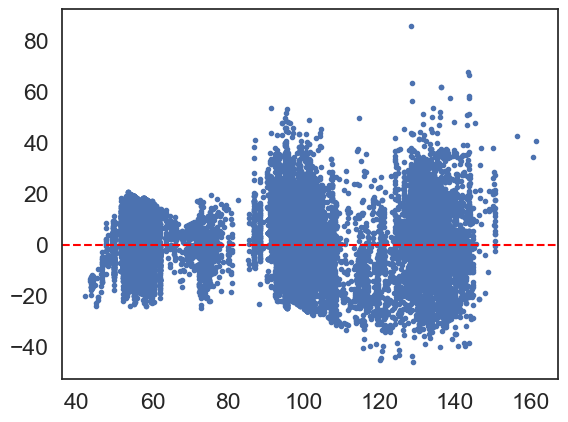

In [19]:
plt.plot(fish_log_glm.fittedvalues, fish_log_glm.resid_deviance, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

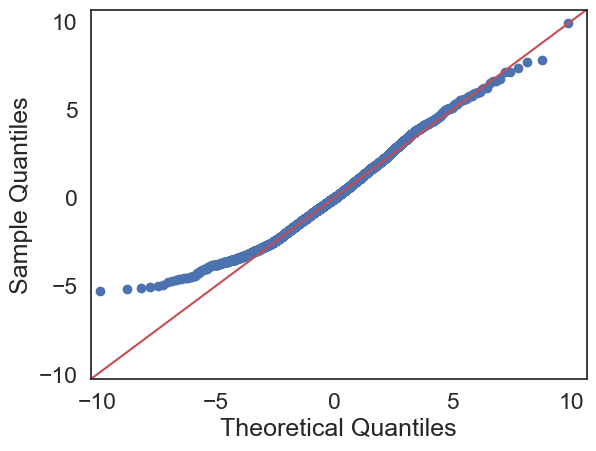

In [20]:
sm.qqplot(fish_log_glm.resid_deviance, dist = scipy.stats.t, fit = True, line = '45');

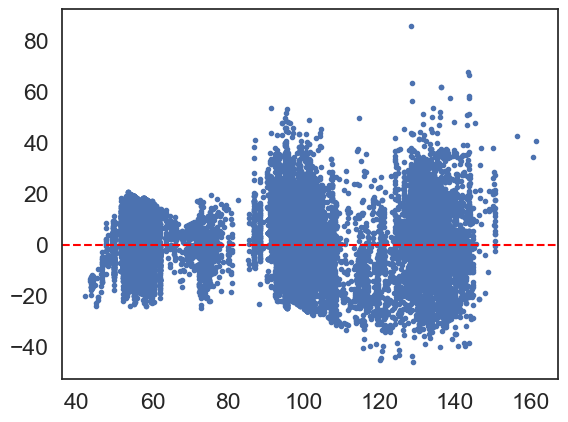

In [21]:
plt.plot(fish_log_glm.fittedvalues, fish_log_glm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

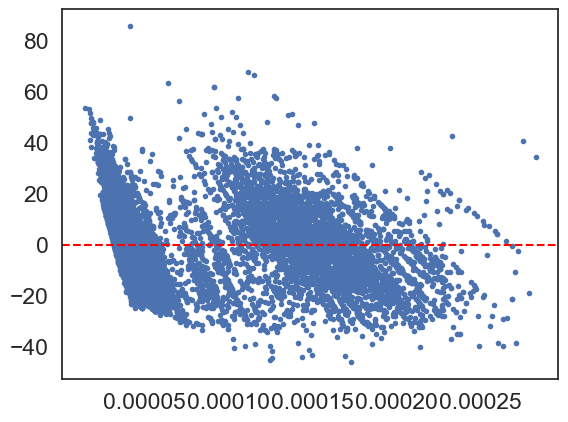

In [22]:
plt.plot(fish_log_glm.get_influence().hat_matrix_diag, fish_log_glm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

## Gamma distribution Inverse Link

In [23]:
fish_gamma_inv_glm = smf.glm('lengthmm~dd', family = sm.families.Gamma() , data = df).fit()
fish_gamma_inv_glm.summary()

c:\Users\adria\.conda\envs\air_to_water\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               lengthmm   No. Observations:                35719
Model:                            GLM   Df Residuals:                    35717
Model Family:                   Gamma   Df Model:                            1
Link Function:          inverse_power   Scale:                        0.019476
Method:                          IRLS   Log-Likelihood:            -1.3273e+05
Date:                Mon, 19 Jun 2023   Deviance:                       695.35
Time:                        14:30:41   Pearson chi2:                     696.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9984
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0222   2.38e-05    931.375      0.000       0.022       0.022
dd         -1.752e-06   3.57e-09   -490.782      0.000   -1.76e-06   -1.75e-06
==============================================================================
"""

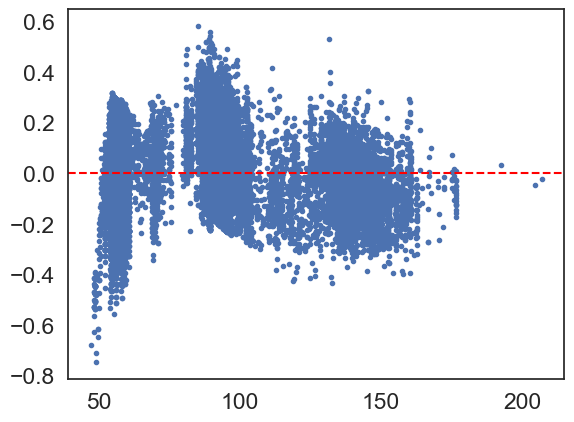

In [24]:
plt.plot(fish_gamma_inv_glm.fittedvalues, fish_gamma_inv_glm.resid_deviance, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

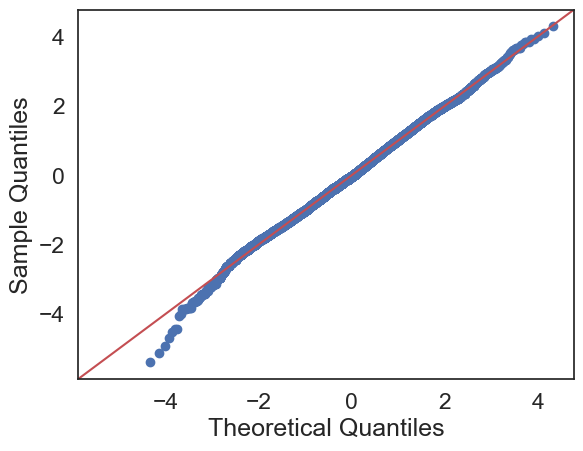

In [25]:
sm.qqplot(fish_gamma_inv_glm.resid_deviance, dist = scipy.stats.t, fit = True, line = '45');

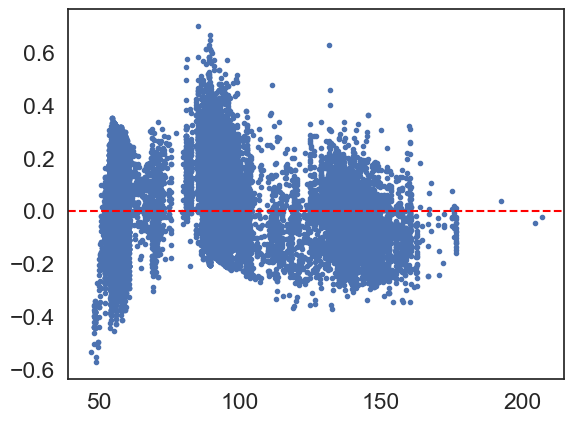

In [26]:
plt.plot(fish_gamma_inv_glm.fittedvalues, fish_gamma_inv_glm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

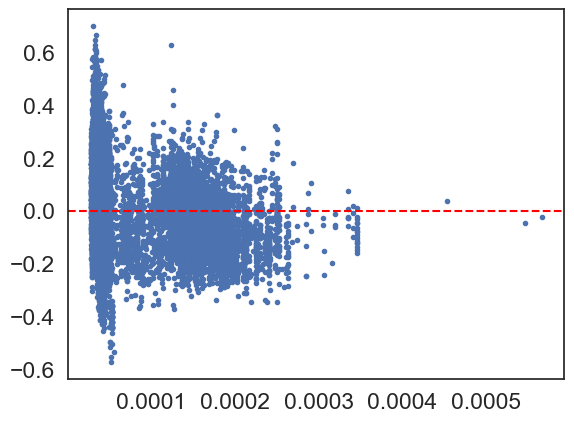

In [27]:
plt.plot(fish_gamma_inv_glm.get_influence().hat_matrix_diag, fish_gamma_inv_glm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

# Gamma distribution Log Link

In [28]:
fish_gamma_log_glm = smf.glm('lengthmm~dd', family = sm.families.Gamma(sm.families.links.log()) , data = df) #df[(df.river != 'Sea-entry')]
fish_gamma_log_glm = fish_gamma_log_glm.fit(cov_type='HAC', cov_kwds = {'maxlags':df[df.lengthmm.isna()].dd.max().round().astype(int)})
fish_gamma_log_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               lengthmm   No. Observations:                35719
Model:                            GLM   Df Residuals:                    35717
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                        0.017110
Method:                          IRLS   Log-Likelihood:            -1.3057e+05
Date:                Mon, 19 Jun 2023   Deviance:                       616.23
Time:                        14:30:45   Pearson chi2:                     611.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9994
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6464      0.011    345.740      0.000       3.626       3.667
dd             0.0001   2.34e-06     62.328      0.000       0.000       0.000
==============================================================================
"""

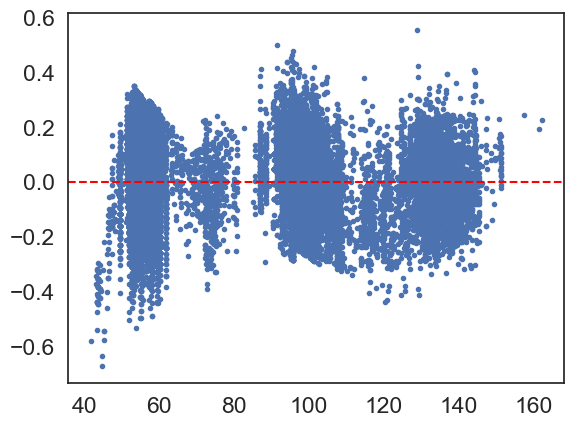

In [29]:
plt.plot(fish_gamma_log_glm.fittedvalues, fish_gamma_log_glm.resid_deviance, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

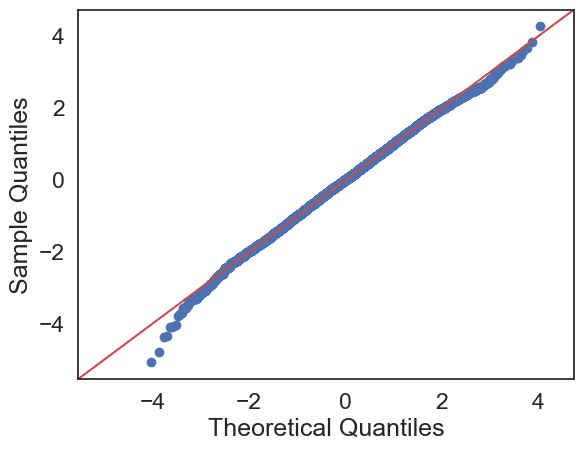

In [30]:
sm.qqplot(fish_gamma_log_glm.resid_deviance, dist = scipy.stats.t, fit = True, line = '45');

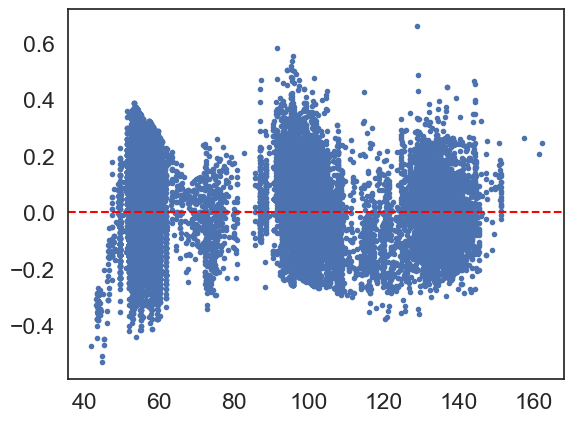

In [31]:
plt.plot(fish_gamma_log_glm.fittedvalues, fish_gamma_log_glm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

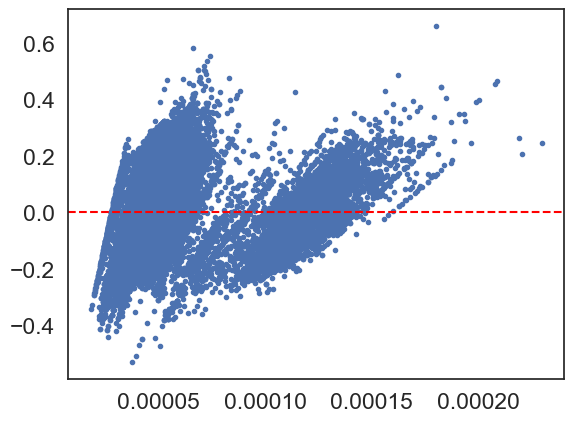

In [32]:
plt.plot(fish_gamma_log_glm.get_influence().hat_matrix_diag, fish_gamma_log_glm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

In [33]:
beta_samp_mean = fish_gamma_log_glm.params
beta_samp_cov = fish_gamma_log_glm.cov_params()
dispersion = fish_gamma_log_glm.scale

X_pred = np.linspace(0, 10000, 10000)
X_pred = sm.tools.add_constant(X_pred)

num_samps = 50000
possible_coefficients = np.random.multivariate_normal(mean = beta_samp_mean, cov = beta_samp_cov, size = num_samps)
linear_predictions = [X_pred@b for b in possible_coefficients]

y_hyp = gamma(a=1/dispersion, scale = np.exp(linear_predictions, order = 'K')*dispersion).rvs()

l, u = np.quantile(y_hyp, q = [0.025, 0.975], axis = 0)

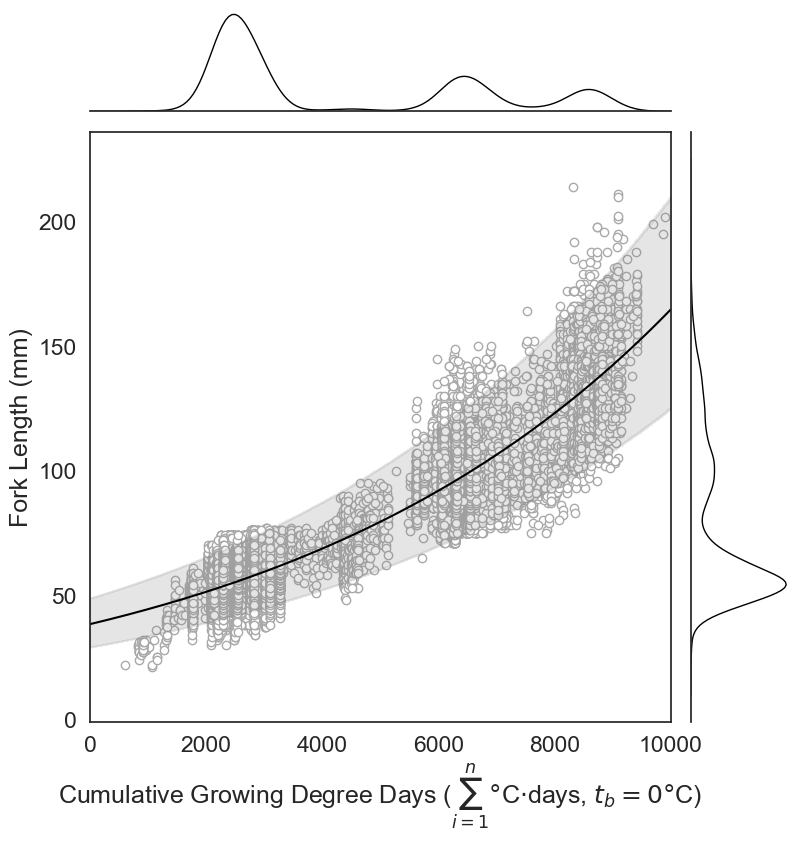

In [34]:
from matplotlib.pyplot import cm

sns.set_theme(style = 'white', font_scale = 1.5)

graph = sns.JointGrid(xlim = (0, 10000), height = 8)
x, y= df[(df.lengthmm.notna())]['dd'], df[(df.lengthmm.notna())]['lengthmm']
graph.ax_joint.scatter(x, y, color = 'white', edgecolor = 'darkgray')
sns.kdeplot(y = y, ax = graph.ax_marg_y, color = 'black', linewidth = 1)
sns.kdeplot(x = x, ax = graph.ax_marg_x, color = 'black', linewidth = 1)
XX = pd.DataFrame({'dd': np.arange(0, 10000)})

#graph.ax_joint.plot(XX_new.dd, fish_gamma_inv_glm.predict(XX_new), color = 'black')
#color = iter(cm.rainbow(np.linspace(0, 1, len(XX_new.river.unique()))))
#for river in XX_new.river.unique():
#    c = next(color)
#    fish_gamma_log_glm.predict(XX_new[XX_new.river == river])
graph.ax_joint.plot(XX.dd, fish_gamma_log_glm.predict(XX), color = 'black')
graph.ax_joint.fill_between(X_pred[:, 1], l, u, color = 'gray', alpha = 0.2)
graph.set_axis_labels(xlabel = r'Cumulative Growing Degree Days ($\sum^{n}_{i=1}$$\degree$C$\cdot$days, $t_b = 0 \degree$C)', ylabel = r'Fork Length (mm)')
sns.despine(ax = graph.ax_joint, right = False, left = False, bottom = False, top = False)
sns.despine(ax = graph.ax_marg_x, right = True, left = True, bottom = False, top = True)
sns.despine(ax = graph.ax_marg_y, right = True, left = False, bottom = True, top = True)

# Notes

We did explore the options of using Generalised Additive Models, but fitting splines to an x-value that will shift disproportionally to seasons (due to photoperiod) will cause smolt growth to occur outside of the possible smolt window. Moreover, potential halting of winter growth may occur in early autumn, which does not make sense from a fish biology perspective. 